In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pyBigWig
import pysam
from tqdm import tqdm
from scipy import stats

In [2]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

# Barn10

### Assemble Metadata

In [3]:
human_bcs = pd.read_csv('Barn10/human_cells.txt', header=None, index_col=False)
human_bcs.columns = ['barcode']
human_bcs['species'] = 'human'
mouse_bcs = pd.read_csv('Barn10/mouse_cells.txt', header=None, index_col=False)
mouse_bcs.columns = ['barcode']
mouse_bcs['species'] = 'mouse'
meta = pd.concat([human_bcs, mouse_bcs])
meta

,barcode,species
0,AATGGCAGAGGAACCTTCAGACTCAGACGAACAAGGCGGTAAGTA,human
1,AATGGCAGAGGAATGGTGTGACTCCGAACTTGAAGGGACAGCATA,human
2,ACCTCGTAAGGAAAGGTGACACTCAGGTCGTAAAGGCTGTGAACA,human
3,ACCTCGTAAGGAAAGGTGACACTCTCCAGTCTAAGGACATCGTCA,human
4,ACCTCGTAAGGAAGACCGATACTCGTGTGATGAAGGGTGACTCTA,human
...,...,...
97,TGTGGTTGAGGAATGGTGTGACTCTATGCGACAAGGCGGTTGATA,mouse
98,TGTGGTTGAGGACTGCTCAAACTCTGCTATGGAAGGTTGATGGCA,mouse
99,TGTGGTTGAGGAGATACCGAACTCAGAATGCCAAGGTCCTCAACA,mouse
100,TGTGGTTGAGGAGGAACCAAACTCTCCAGTCTAAGGTTGATGGCA,mouse


In [4]:
well_to_bc = {
    "A1":"GTAACCGA",
    "A2":"TCCTCAAC",
    "A3":"TGGTCTCA",
    "B1":"GTCCGATT",
    "B2":"TTGACCAC",
    "B3":"TCCAGGAT",
    "C1":"GACAGCAT",
    "C2":"GATGGTCT",
    "C3":"CATACCGT",
    "D1":"CGGTTGAT",
    "D2":"CGACCTAT",
    "D3":"TTCCACTC",
    "E1":"CGGTAAGT",
    "E2":"GTGACTCT",
    "E3":"CTGTGAAC",
    "F1":"TGACAGTG",
    "F2":"GGCATCAA",
    "F3":"ACATCGTC",
    "G1":"CACTGACA",
    "G2":"AGATACCG",
    "G3":"TTGGATGC",
    "H1":"GTCGGTAA",
    "H2":"TTGATGGC",
    "H3":"GTTACGGT"
}

condition_to_well = {
    "mMDA": ["A1", "B1", "C1", "D1", "E1", "F1", "G1","A2", "B2", "C2", "D2", "E2", "F2", "G2"],
    "PTA": ["H1", "H2", "A3", "B3", "C3", "D3", "E3", "F3", "G3","H3"] # double check with Sanjay if H1 is actually PTA
}

In [5]:
PTA = [well_to_bc[k] for k in condition_to_well["PTA"]]
mMDA = [well_to_bc[k] for k in condition_to_well["mMDA"]]

In [6]:
def classify(row):
    if row['barcode'][-9:-1] in PTA:
        return 'PTA'
    elif row['barcode'][-9:-1] in mMDA:
        return 'mMDA'
meta['amplification'] = meta.apply(classify, axis=1)
meta

,barcode,species,amplification
0,AATGGCAGAGGAACCTTCAGACTCAGACGAACAAGGCGGTAAGTA,human,mMDA
1,AATGGCAGAGGAATGGTGTGACTCCGAACTTGAAGGGACAGCATA,human,mMDA
2,ACCTCGTAAGGAAAGGTGACACTCAGGTCGTAAAGGCTGTGAACA,human,PTA
3,ACCTCGTAAGGAAAGGTGACACTCTCCAGTCTAAGGACATCGTCA,human,PTA
4,ACCTCGTAAGGAAGACCGATACTCGTGTGATGAAGGGTGACTCTA,human,mMDA
...,...,...,...
97,TGTGGTTGAGGAATGGTGTGACTCTATGCGACAAGGCGGTTGATA,mouse,mMDA
98,TGTGGTTGAGGACTGCTCAAACTCTGCTATGGAAGGTTGATGGCA,mouse,PTA
99,TGTGGTTGAGGAGATACCGAACTCAGAATGCCAAGGTCCTCAACA,mouse,mMDA
100,TGTGGTTGAGGAGGAACCAAACTCTCCAGTCTAAGGTTGATGGCA,mouse,PTA


In [7]:
read_counts = pd.read_csv('Barn10/readcounts.csv')
# read_counts[read_counts['barcode'].isin(meta['barcode'])]
meta = pd.merge(meta, read_counts, on='barcode', how='left')

In [8]:
meta['read_count'].mean()

1433349.43814433

### Comparison of readcounts

In [9]:
t_stat, p_value = stats.ttest_ind(meta[meta['amplification'] == 'mMDA']['read_count'], meta[meta['amplification'] == 'PTA']['read_count'])

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: -4.923137263395776
P-value: 1.8293923730372927e-06


In [10]:
t_stat, p_value = stats.ttest_ind(np.log10(meta[meta['amplification'] == 'mMDA']['read_count']), np.log10(meta[meta['amplification'] == 'PTA']['read_count']))
print("log transformed:")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

log transformed:
T-statistic: -10.653819753583027
P-value: 4.039531088560295e-21


/loc/scratch/14149503/ipykernel_20468/3395006003.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=meta, x="amplification", y="read_count",


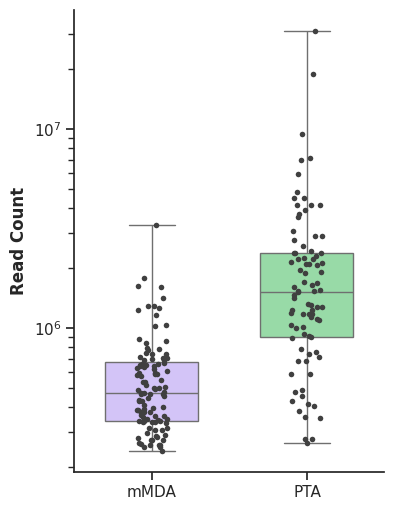

In [11]:
sns.set_theme(style="ticks", palette="pastel")
fig,ax = plt.subplots(1,1,figsize=(4,6))
sns.boxplot(data=meta, x="amplification", y="read_count",
            ax=ax,
            palette=["m", "g"],
            whis=[0, 100],
            width=.6
           )
sns.stripplot(data=meta, x="amplification", y="read_count",
              ax=ax,
              size=4, 
              color=".25"
             )

plt.yscale('log')
sns.despine()
plt.xlabel('')
plt.ylabel('Read Count', fontdict={'weight':'bold'})
plt.savefig('Barn10/Barn10_mMDA_PTA_RC.png', dpi=600, bbox_inches='tight')
plt.savefig('Barn10/Barn10_mMDA_PTA_RC.pdf', bbox_inches='tight')

### Quantifying Coverage Distribution:

lorenz curve, gini coefficient

In [12]:
human_cells = meta[meta['species']=='human']['barcode'].to_list()
mouse_cells = meta[meta['species']=='mouse']['barcode'].to_list()

In [13]:
human_coverages = {bc : pd.read_csv(f"Barn10/human_sc_outs/sc_output/{bc}_binned_coverage.csv", header=None)[0].to_list() for bc in human_cells}
human_coverages = pd.DataFrame(data=human_coverages)

In [14]:
human_meta = meta[meta['species']=='human']
ginis = []
for bc in human_meta['barcode']:
    prop = human_coverages[bc] / human_coverages[bc].sum()
    prop = prop[prop>0] 
    y = np.cumsum(prop.sort_values())
    x = np.arange(len(prop))
    x = x / len(x)
    x = np.concatenate(([0], x))
    y = np.concatenate(([0], y))
    auc = np.trapz(y, x)
    gini = 1 - 2 * auc
    ginis.append(gini)
human_meta['gini'] = ginis
human_meta

/loc/scratch/14149503/ipykernel_20468/2596621896.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_meta['gini'] = ginis


,barcode,species,amplification,read_count,gini
0,AATGGCAGAGGAACCTTCAGACTCAGACGAACAAGGCGGTAAGTA,human,mMDA,337965,0.244214
1,AATGGCAGAGGAATGGTGTGACTCCGAACTTGAAGGGACAGCATA,human,mMDA,781265,0.238023
2,ACCTCGTAAGGAAAGGTGACACTCAGGTCGTAAAGGCTGTGAACA,human,PTA,2077421,0.235135
3,ACCTCGTAAGGAAAGGTGACACTCTCCAGTCTAAGGACATCGTCA,human,PTA,1705793,0.239460
4,ACCTCGTAAGGAAGACCGATACTCGTGTGATGAAGGGTGACTCTA,human,mMDA,1631210,0.242748
...,...,...,...,...,...
87,TATCAGCCAGGACGCTACTAACTCGCAATGACAAGGCGGTTGATA,human,mMDA,1166328,0.243414
88,TATCAGCCAGGACTTCAGCAACTCTGCTATGGAAGGTTCCACTCA,human,PTA,4488893,0.264159
89,TGTGGTTGAGGACCATACGAACTCGTGTGATGAAGGGGCATCAAA,human,mMDA,773959,0.253611
90,TGTGGTTGAGGACTTCAGCAACTCTAACGGAGAAGGAGATACCGA,human,mMDA,263406,0.249797


In [15]:
mouse_coverages = {bc : pd.read_csv(f"Barn10/mouse_sc_outs/sc_output/{bc}_binned_coverage.csv", header=None)[0].to_list() for bc in mouse_cells}
mouse_coverages = pd.DataFrame(data=mouse_coverages)

In [16]:
mouse_meta = meta[meta['species']=='mouse']
ginis = []
for bc in mouse_meta['barcode']:
    prop = mouse_coverages[bc] / mouse_coverages[bc].sum()
    prop = prop[prop>0] 
    y = np.cumsum(prop.sort_values())
    x = np.arange(len(prop))
    x = x / len(x)
    x = np.concatenate(([0], x))
    y = np.concatenate(([0], y))
    auc = np.trapz(y, x)
    gini = 1 - 2 * auc
    ginis.append(gini)
mouse_meta['gini'] = ginis
mouse_meta

/loc/scratch/14149503/ipykernel_20468/3412426701.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mouse_meta['gini'] = ginis


,barcode,species,amplification,read_count,gini
92,AATGGCAGAGGAATGGTGTGACTCACAGTAGCAAGGGTTACGGTA,mouse,PTA,2583761,0.246453
93,AATGGCAGAGGACTTCAGCAACTCTGTTGGACAAGGACATCGTCA,mouse,PTA,3754954,0.308889
94,AATGGCAGAGGAGATACCGAACTCACAGTAGCAAGGGACAGCATA,mouse,mMDA,399453,0.246204
95,ACCTCGTAAGGAAAGGTGACACTCCACCATCTAAGGCGACCTATA,mouse,mMDA,278293,0.235717
96,ACCTCGTAAGGAAGGCATTGACTCCACCATCTAAGGCTGTGAACA,mouse,PTA,4166201,0.300293
...,...,...,...,...,...
189,TGTGGTTGAGGAATGGTGTGACTCTATGCGACAAGGCGGTTGATA,mouse,mMDA,1778604,0.248589
190,TGTGGTTGAGGACTGCTCAAACTCTGCTATGGAAGGTTGATGGCA,mouse,PTA,588096,0.491253
191,TGTGGTTGAGGAGATACCGAACTCAGAATGCCAAGGTCCTCAACA,mouse,mMDA,741998,0.250969
192,TGTGGTTGAGGAGGAACCAAACTCTCCAGTCTAAGGTTGATGGCA,mouse,PTA,1948880,0.262363


In [17]:
meta = pd.concat([human_meta, mouse_meta])
meta

,barcode,species,amplification,read_count,gini
0,AATGGCAGAGGAACCTTCAGACTCAGACGAACAAGGCGGTAAGTA,human,mMDA,337965,0.244214
1,AATGGCAGAGGAATGGTGTGACTCCGAACTTGAAGGGACAGCATA,human,mMDA,781265,0.238023
2,ACCTCGTAAGGAAAGGTGACACTCAGGTCGTAAAGGCTGTGAACA,human,PTA,2077421,0.235135
3,ACCTCGTAAGGAAAGGTGACACTCTCCAGTCTAAGGACATCGTCA,human,PTA,1705793,0.239460
4,ACCTCGTAAGGAAGACCGATACTCGTGTGATGAAGGGTGACTCTA,human,mMDA,1631210,0.242748
...,...,...,...,...,...
189,TGTGGTTGAGGAATGGTGTGACTCTATGCGACAAGGCGGTTGATA,mouse,mMDA,1778604,0.248589
190,TGTGGTTGAGGACTGCTCAAACTCTGCTATGGAAGGTTGATGGCA,mouse,PTA,588096,0.491253
191,TGTGGTTGAGGAGATACCGAACTCAGAATGCCAAGGTCCTCAACA,mouse,mMDA,741998,0.250969
192,TGTGGTTGAGGAGGAACCAAACTCTCCAGTCTAAGGTTGATGGCA,mouse,PTA,1948880,0.262363


In [18]:
meta.to_csv('Barn10/barn10_metadata.csv')

In [24]:
print(f"mMDA: {meta[meta['amplification']=='mMDA']['gini'].mean()}")
print(f"PTA: {meta[meta['amplification']=='PTA']['gini'].mean()}")

mMDA: 0.23575443848270417
PTA: 0.27669632007493616


In [20]:
t_stat, p_value = stats.ttest_ind(meta[meta['amplification'] == 'mMDA']['gini'], meta[meta['amplification'] == 'PTA']['gini'])

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: -4.359090590162343
P-value: 2.1265986119299628e-05


/tmp/ipykernel_19824/3576449637.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=meta, x="amplification", y="gini",


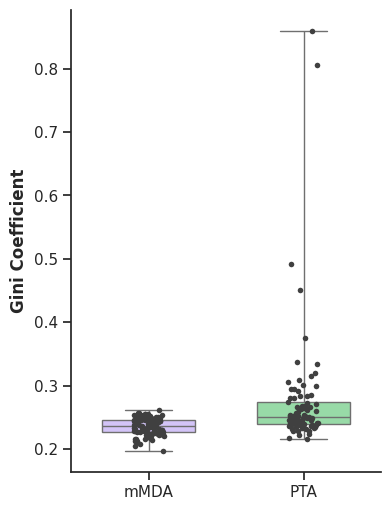

In [21]:
sns.set_theme(style="ticks", palette="pastel")
fig,ax = plt.subplots(1,1,figsize=(4,6))
sns.boxplot(data=meta, x="amplification", y="gini",
            ax=ax,
            palette=["m", "g"],
            whis=(0,100),
            width=.6
           )

sns.stripplot(data=meta, x="amplification", y="gini",
              ax=ax,
              size=4, 
              color=".25"
             )

sns.despine()
plt.xlabel('')
# plt.ylim(0.175,0.4)
plt.ylabel('Gini Coefficient', fontdict={'weight':'bold'})
plt.savefig('Barn10/Barn10_gini.png', dpi=600, bbox_inches='tight')
plt.savefig('Barn10/Barn10_gini.pdf', bbox_inches='tight')

In [21]:
lorenz_curves = {}
for bc in meta['barcode']:
    species = meta[meta['barcode']==bc]['species'].values[0]
    if species == 'mouse':
        prop = mouse_coverages[bc] / mouse_coverages[bc].sum()
        prop = prop[prop>0] 
        y = np.cumsum(prop.sort_values())
        x = np.arange(len(prop))
        x = x / len(x)
        x = np.concatenate(([0], x))
        y = np.concatenate(([0], y))
        lorenz_curves[bc] = y
    elif species == 'human':
        prop = human_coverages[bc] / human_coverages[bc].sum()
        prop = prop[prop>0] 
        y = np.cumsum(prop.sort_values())
        x = np.arange(len(prop))
        x = x / len(x)
        x = np.concatenate(([0], x))
        y = np.concatenate(([0], y))
        lorenz_curves[bc] = y

common_x = np.linspace(0, 1, 100)

for bc,arr in lorenz_curves.items():
    # Original x scale for the array (0 to 1, evenly spaced)
    original_x = np.linspace(0, 1, len(arr))
    # Interpolate to the common scale
    rescaled_y = np.interp(common_x, original_x, arr)
    lorenz_curves[bc]=rescaled_y

lorenz_curves = pd.DataFrame(data=lorenz_curves, index=common_x)


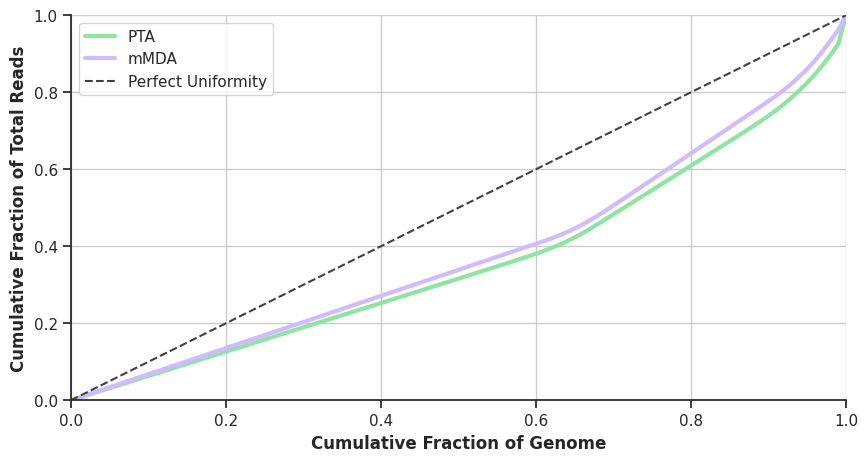

In [22]:
# Group metadata by the desired category (e.g., 'species')
grouped_meta = meta.groupby('amplification')['barcode']

# Calculate mean and standard deviation of Lorenz curves for each group
mean_curves = {}
std_curves = {}
for group, barcodes in grouped_meta:
    subset = lorenz_curves[barcodes]  # Select Lorenz curves for the group
    mean_curves[group] = subset.mean(axis=1)  # Mean across barcodes
    std_curves[group] = subset.std(axis=1)    # Standard deviation across barcodes

# Convert to DataFrame for plotting
mean_df = pd.DataFrame(mean_curves)
std_df = pd.DataFrame(std_curves)

plt.figure(figsize=(10, 5))
plt.plot(common_x, mean_df['PTA'], label='PTA', color='g', linewidth=3)
plt.plot(common_x, mean_df['mMDA'], label='mMDA', color='m', linewidth=3)
plt.grid(True)
plt.plot([0,1],[0,1], color='.25', linestyle='--', label='Perfect Uniformity')
plt.legend(title='')
sns.despine()
plt.ylim(0,1)
plt.xlim(0,1)
plt.xlabel('Cumulative Fraction of Genome', fontdict={'weight':'bold'})
plt.ylabel('Cumulative Fraction of Total Reads', fontdict={'weight':'bold'})
plt.savefig('Barn10/Barn10_lorenz.png', dpi=600, bbox_inches='tight')
plt.savefig('Barn10/Barn10_lorenz.pdf', bbox_inches='tight')

In [23]:
mean_df.to_csv('Barn10/lorenz.csv')

### Visualizing Coverage

In [49]:
top_mMDA_human = meta[(meta['amplification']=='mMDA') & (meta['species']=='human')].sort_values(by='gini', ascending=True).iloc[:6]
top_mMDA_human

,barcode,species,amplification,read_count,gini
35,CAACTTGCAGGAAGATGGTCACTCTATGCGACAAGGGATGGTCTA,human,mMDA,256123,0.197249
86,TACCACAGAGGATTGGTAGCACTCGTGTGATGAAGGCGACCTATA,human,mMDA,473361,0.205535
33,CAACTTGCAGGAAAGGTGACACTCTACAACCGAAGGAGATACCGA,human,mMDA,240687,0.207366
7,ACTAACCGAGGAAAGGTGACACTCCGAACTTGAAGGGATGGTCTA,human,mMDA,531452,0.212015
36,CAACTTGCAGGATGGTCACTACTCTCCAGTCTAAGGCGGTTGATA,human,mMDA,348033,0.214423
28,CAACCAACAGGAAGGCATTGACTCTCTGCTTGAAGGGGCATCAAA,human,mMDA,274111,0.215751


In [50]:
top_mMDA_mouse = meta[(meta['amplification']=='mMDA') & (meta['species']=='mouse')].sort_values(by='gini', ascending=True).iloc[:6]
top_mMDA_mouse

,barcode,species,amplification,read_count,gini
129,CAACTTGCAGGAAGGCTAACACTCGTGTGATGAAGGGACAGCATA,mouse,mMDA,697995,0.211859
101,ACTAACCGAGGAATGGTGTGACTCAGGTCGTAAAGGCGACCTATA,mouse,mMDA,250269,0.212513
108,AGGTCCAAAGGATGGTCACTACTCAGCATTGGAAGGGATGGTCTA,mouse,mMDA,581656,0.215701
150,GGTCTCATAGGATGGTCACTACTCAGAATGCCAAGGCGACCTATA,mouse,mMDA,505946,0.216104
131,CAACTTGCAGGATTGGTAGCACTCGGAACTGTAAGGGATGGTCTA,mouse,mMDA,594760,0.220443
149,GGTCTCATAGGAGATACCGAACTCTACAACCGAAGGCGACCTATA,mouse,mMDA,651491,0.222421


In [47]:
top_PTA_human = meta[(meta['amplification']=='PTA') & (meta['species']=='human')].sort_values(by='gini', ascending=True).iloc[:6]
top_PTA_human

,barcode,species,amplification,read_count,gini
10,AGGTCCAAAGGAAGACCGATACTCACAGTAGCAAGGGTCGGTAAA,human,PTA,405405,0.217207
61,GGTCTCATAGGAAGGCATTGACTCTGTTGGACAAGGTTGGATGCA,human,PTA,783261,0.222883
85,TACCACAGAGGATGGTCACTACTCAGGTCGTAAAGGGTCGGTAAA,human,PTA,415675,0.224268
9,ACTAACCGAGGAGATACCGAACTCTGCTATGGAAGGTTGATGGCA,human,PTA,999444,0.229089
67,GTGAGACTAGGAATGGTGTGACTCGCTGGATAAAGGGTCGGTAAA,human,PTA,488278,0.229146
27,CAACCAACAGGAAACTGCTCACTCTCTGGAACAAGGCATACCGTA,human,PTA,1275627,0.229191


In [48]:
top_PTA_mouse = meta[(meta['amplification']=='PTA') & (meta['species']=='mouse')].sort_values(by='gini', ascending=True).iloc[:6]
top_PTA_mouse

,barcode,species,amplification,read_count,gini
109,AGGTCCAAAGGATGGTCACTACTCTATGCGACAAGGGTCGGTAAA,mouse,PTA,758801,0.215522
182,TATCAGCCAGGAAGATGGTCACTCACAGTAGCAAGGGTTACGGTA,mouse,PTA,1539224,0.233171
128,CAACCAACAGGAGATACCGAACTCACAGTAGCAAGGACATCGTCA,mouse,PTA,1675579,0.233416
100,ACTAACCGAGGAAGGCATTGACTCTGCTATGGAAGGTTGGATGCA,mouse,PTA,1186400,0.234823
151,GGTCTCATAGGATGGTCACTACTCTCTGCTTGAAGGACATCGTCA,mouse,PTA,2099599,0.236119
172,TACCACAGAGGAAACGATGGACTCTATGCGACAAGGGTCGGTAAA,mouse,PTA,885640,0.236341


In [51]:
cell = 'AGGTCCAAAGGAAGACCGATACTCACAGTAGCAAGGGTCGGTAAA'
bw = pyBigWig.open(f"Barn10/human_sc_outs/sc_output/{cell}.bw")

chrom='chr1_hg38'
chrom_len = bw.chroms()[chrom]
MDA_coverage = bw.values(chrom, 0, chrom_len)
bw.close()

# Define the bin size (e.g., 1000 base pairs per bin)
bin_size = 1000

# Compute the number of bins
num_bins = len(coverage) // bin_size

# Downsample the coverage array by computing the mean for each bin
binned_positions = np.arange(0, chrom_len, bin_size)
binned_coverage = [
    np.nanmean(coverage[i:i + bin_size]) for i in range(0, len(coverage), bin_size)
]

# If there's an extra bin for the remainder, extend binned_positions accordingly
if len(binned_coverage) > len(binned_positions):
    binned_positions = np.append(binned_positions, chrom_length)

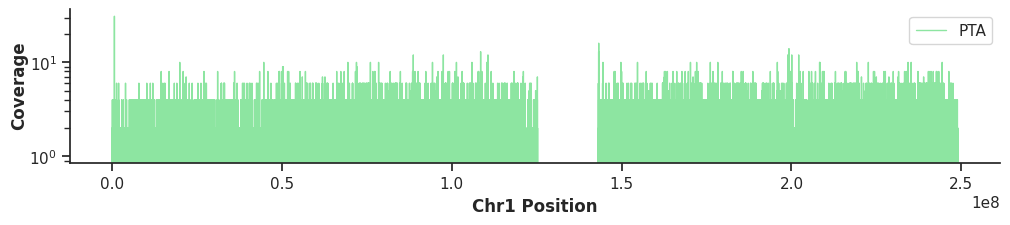

In [55]:
sns.set_theme(style="ticks", palette="pastel")

fig,ax = plt.subplots(1,1,figsize=(12,2))

sns.lineplot(x=binned_positions[:len(binned_coverage)+1], y=binned_coverage, color='g', lw=1, label='PTA', ax=ax)
ax.set_yscale('log')
ax.set_xlabel('Chr1 Position', fontsize=12, fontweight='bold')
fig.text(0.075, 0.5, 'Coverage', va='center', rotation='vertical', fontsize=12, fontweight='bold')
sns.despine()

In [71]:

chrom_order

['chr1_hg38',
 'chr2_hg38',
 'chr3_hg38',
 'chr4_hg38',
 'chr5_hg38',
 'chr6_hg38',
 'chr7_hg38',
 'chr8_hg38',
 'chr9_hg38',
 'chr10_hg38',
 'chr11_hg38',
 'chr12_hg38',
 'chr13_hg38',
 'chr14_hg38',
 'chr15_hg38',
 'chr16_hg38',
 'chr17_hg38',
 'chr18_hg38',
 'chr19_hg38',
 'chr20_hg38',
 'chr21_hg38',
 'chr22_hg38',
 'chrX_hg38']

In [109]:
cell = 'AGGTCCAAAGGAAGACCGATACTCACAGTAGCAAGGGTCGGTAAA'
bw = pyBigWig.open(f"Barn10/human_sc_outs/sc_output/{cell}.bw")

# Retrieve chromosome sizes and order them
chrom_sizes = bw.chroms()
chrom_order = [f"chr{i}_hg38" for i in range(1,23)]
chrom_order += ['chrX_hg38']

bin_size = 1000
gap_size = 10000000  # Define a gap between chromosomes
binned_positions = []
binned_coverage = []
chrom_offsets = {}
curr_offset = 0

for chrom in chrom_order:
    chrom_len = chrom_sizes[chrom]
    print(chrom, ',', chrom_len)
    coverage = bw.values(chrom, 0, chrom_len)
    
    num_bins = len(coverage) // bin_size
    binned_pos = np.arange(curr_offset, curr_offset + chrom_len, bin_size)
    binned_cov = [np.nanmean(coverage[i:i + bin_size]) for i in range(0, len(coverage), bin_size)]
    
    if len(binned_cov) > len(binned_pos):
        binned_pos = np.append(binned_pos, curr_offset + chrom_len)
    
    chrom_offsets[chrom] = (curr_offset, curr_offset + chrom_len)
    curr_offset += chrom_len + gap_size  # Add a gap between chromosomes
    
    binned_positions.extend(binned_pos)
    binned_coverage.extend(binned_cov)

bw.close()


chr1_hg38 , 248956422
chr2_hg38 , 242193529
chr3_hg38 , 198295559
chr4_hg38 , 190214555
chr5_hg38 , 181538259
chr6_hg38 , 170805979
chr7_hg38 , 159345973
chr8_hg38 , 145138636
chr9_hg38 , 138394717
chr10_hg38 , 133797422
chr11_hg38 , 135086622
chr12_hg38 , 133275309
chr13_hg38 , 114364328
chr14_hg38 , 107043718
chr15_hg38 , 101991189
chr16_hg38 , 90338345
chr17_hg38 , 83257441
chr18_hg38 , 80373285
chr19_hg38 , 58617616
chr20_hg38 , 64444167
chr21_hg38 , 46709983
chr22_hg38 , 50818468
chrX_hg38 , 156040895


/tmp/ipykernel_19824/2234508916.py:6: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0,15)


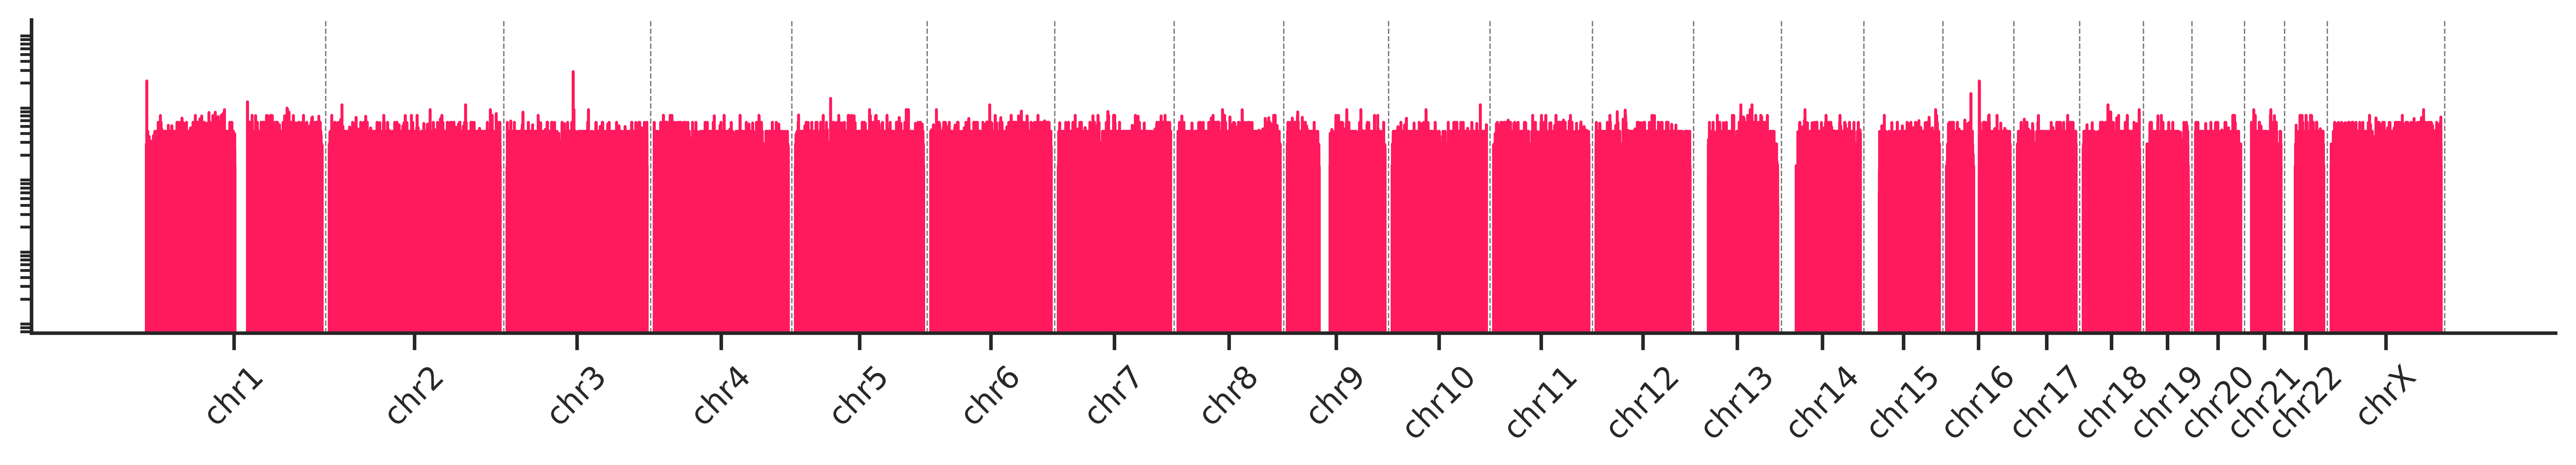

In [116]:
# sns.set_theme(style="ticks")
fig, ax = plt.subplots(1, 1, figsize=(16, 2), dpi=600)

sns.lineplot(x=binned_positions[:len(binned_coverage)], y=binned_coverage, color='#ff1a5e', lw=1, ax=ax)
ax.set_yscale('log')
ax.set_ylim(0,15)
# ax.set_xlabel('Genomic Position', fontsize=10, fontweight='bold')
# fig.text(0.075, 0.5, 'Coverage', va='center', rotation='vertical', fontsize=12, fontweight='bold')

# Add chromosome labels
# for chrom, (start, end) in chrom_offsets.items():
    # mid = (start + end) / 2
    # ax.text(mid, ax.get_ylim()[1], chrom[:-5], fontsize=8, verticalalignment='top', rotation=45,horizontalalignment='center')
for chrom, (start,end) in chrom_offsets.items():
    ax.axvline(x=end+5000000, color='gray', linestyle='--', lw=0.5)
ax.set_xticks(ticks = [(start + end) / 2 for (start, end) in chrom_offsets.values()], labels = [chrom[:-5] for chrom in chrom_order],rotation=45)
ax.set_yticks([])
# plt.savefig(f'Barn10/{cell}_track.png', dpi=600, bbox_inches='tight')
sns.despine()
fig.savefig('test_cov_track.png', bbox_inches='tight')

In [117]:
cell = 'AGGTCCAAAGGAAGACCGATACTCACAGTAGCAAGGGTCGGTAAA'
bw = pyBigWig.open(f"Barn10/human_sc_outs/sc_output/{cell}.bw")

chrom='chr1_hg38'
chrom_len = bw.chroms()[chrom]
coverage = bw.values(chrom, 0, chrom_len)
bw.close()

# Define the bin size (e.g., 1000 base pairs per bin)
bin_size = 1000

# Compute the number of bins
num_bins = len(coverage) // bin_size

# Downsample the coverage array by computing the mean for each bin
binned_positions = np.arange(0, chrom_len, bin_size)
binned_coverage = [
    np.nanmean(coverage[i:i + bin_size]) for i in range(0, len(coverage), bin_size)
]

# If there's an extra bin for the remainder, extend binned_positions accordingly
if len(binned_coverage) > len(binned_positions):
    binned_positions = np.append(binned_positions, chrom_length)

In [123]:
species = 'mouse'
if species == 'human':
    test = [f"chr{i}_hg38" for i in range(1,23)]
    test += ['chrX_hg38']

elif species == 'mouse':
    test = [f"chr{i}_mm10" for i in range(1,20)]
    test += ['chrX_mm10']
print(test)

['chr1_hg38', 'chr2_hg38', 'chr3_hg38', 'chr4_hg38', 'chr5_hg38', 'chr6_hg38', 'chr7_hg38', 'chr8_hg38', 'chr9_hg38', 'chr10_hg38', 'chr11_hg38', 'chr12_hg38', 'chr13_hg38', 'chr14_hg38', 'chr15_hg38', 'chr16_hg38', 'chr17_hg38', 'chr18_hg38', 'chr19_hg38', 'chr20_hg38', 'chr21_hg38', 'chr22_hg38', 'chrX_hg38']


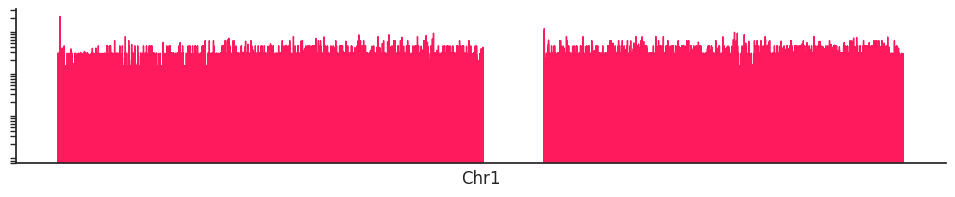

In [119]:
fig,ax = plt.subplots(1,1,figsize=(12,2))

sns.lineplot(x=binned_positions[:len(binned_coverage)+1], y=binned_coverage, color='#ff1a5e', lw=1, ax=ax)
ax.set_yscale('log')
ax.set_xlabel('Chr1', fontsize=12)

ax.set_yticks([])
ax.set_xticks([])

sns.despine()

In [122]:
# AGGTCCAAAGGATGGTCACTACTCTATGCGACAAGGGTCGGTAAA
cell = 'AGGTCCAAAGGATGGTCACTACTCTATGCGACAAGGGTCGGTAAA'
bw = pyBigWig.open(f"Barn10/mouse_sc_outs/sc_output/{cell}.bw")

# chrom='chr1_hg38'
# chrom_len = bw.chroms()[chrom]
print(bw.chroms())
# coverage = bw.values(chrom, 0, chrom_len)
bw.close()


{'chr10_mm10': 130694993, 'chr11_mm10': 122082543, 'chr12_mm10': 120129022, 'chr13_mm10': 120421639, 'chr14_mm10': 124902244, 'chr15_mm10': 104043685, 'chr16_mm10': 98207768, 'chr17_mm10': 94987271, 'chr18_mm10': 90702639, 'chr19_mm10': 61431566, 'chr1_mm10': 195471971, 'chr2_mm10': 182113224, 'chr3_mm10': 160039680, 'chr4_mm10': 156508116, 'chr5_mm10': 151834684, 'chr6_mm10': 149736546, 'chr7_mm10': 145441459, 'chr8_mm10': 129401213, 'chr9_mm10': 124595110, 'chrM_mm10': 16299, 'chrX_mm10': 171031299, 'chrY_mm10': 91744698, 'chr1_hg38': 248956422, 'chr2_hg38': 242193529, 'chr3_hg38': 198295559, 'chr4_hg38': 190214555, 'chr5_hg38': 181538259, 'chr6_hg38': 170805979, 'chr7_hg38': 159345973, 'chr8_hg38': 145138636, 'chr9_hg38': 138394717, 'chr10_hg38': 133797422, 'chr11_hg38': 135086622, 'chr12_hg38': 133275309, 'chr13_hg38': 114364328, 'chr14_hg38': 107043718, 'chr15_hg38': 101991189, 'chr16_hg38': 90338345, 'chr17_hg38': 83257441, 'chr18_hg38': 80373285, 'chr19_hg38': 58617616, 'chr20_h